## Import Modules

In [31]:
import os
import math
from io import BytesIO
import lmdb
import tqdm
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import make_grid
# from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

## Dataset Tool

In [2]:
class AnimeFace(Dataset):
    def __init__(
        self, 
        root_folder='/amax/data/LHao/dataset/', 
        transform=None, 
        sizes=(4, 8, 16, 32, 64), 
        db_path='./lmdb_data', 
        resolution=64
    ):
        super().__init__()
        self.sizes = sizes
        self.resolution = resolution
        imgs = ImageFolder(root_folder)
        self._save_db(imgs, db_path)
        self._db = lmdb.open(db_path)
        self.transform = transform
        
    def _save_db(self, files, db_path):
        img_count = 0
        db = lmdb.open(db_path, map_size=1024 ** 4)
        with db.begin(write=True) as file:
            for i, (original_img, _) in enumerate(files.imgs):
                resize_imgs = self._resize_resolution(original_img)
                for size, img in zip(self.sizes, resize_imgs):
                    key = f'{size}-{str(i).zfill(5)}'
                    file.put(key.encode('utf-8'), img)
                img_count += 1
            file.put('length'.encode('utf-8'), str(img_count).encode('utf-8'))
            self._length = img_count
        db.close()
        
    def _resize_resolution(self, img):
        imgs = []
        img = Image.open(img)
        for size in self.sizes:
            buffer = BytesIO()
            img_resize = transforms.F.resize(img, size)
            img_resize = transforms.F.center_crop(img_resize, size)
            img_resize.save(buffer, format='jpeg')
            imgs.append(buffer.getvalue())
        return imgs
                
    def __len__(self):
        return self._length
    
    def __getitem__(self, index):
        with self._db.begin(write=False) as file:
            img_bytes = file.get(f'{self.resolution}-{str(index).zfill(5)}'.encode())
        buffer = BytesIO(img_bytes)
        img = Image.open(buffer)
        if self.transform:
            img = self.transform(img)
        return img
    
    def __del__(self):
        self._db.close()
        
    def show(self, index):
        plt.imshow(self[index].permute(1, 2, 0))

## Generator

In [3]:
class StyledGenerator(nn.Module):
    def __init__(self, num_resolution, w_channel=512, device=torch.device('cpu')):
        super().__init__()
        self.mapping = MappingNetwork()
        self.synthesis = SynthesisNetwork(num_resolution, w_channel=w_channel, device=device)

    def forward(self, latent_code, level):
        w = self.mapping(latent_code)
        return self.synthesis(w, level)

### Mapping Network

In [4]:
class MappingNetworkBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.activation = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        return self.activation(self.linear(x))

class MappingNetwork(nn.Module):
    def __init__(self, latent_in_dim=512, latent_out_dim=512, num_mlp=8, broadcast=18):
        super().__init__()
        self.latent_in_dim = latent_in_dim
        self.broadcast = broadcast
        self.norm = PixelNorm()
        self._mapping = [MappingNetworkBlock(latent_in_dim, latent_out_dim) for i in range(num_mlp)]
        self.mapping = nn.Sequential(*self._mapping)
    
    def forward(self, x):
        x = self.norm(x)
        x = x.view(-1, self.latent_in_dim)
        out = self.mapping(x)
        out = out.unsqueeze(1)
        return out.repeat(1, self.broadcast, 1)

### tools

#### FadeIn

In [5]:
class FadeIn():
    def __init__(self):
        self.alpha = 1e-5
        
    def __call__(self, x, y):
        return x * (1 - self.alpha) + y * self.alpha
    
    def _update_alpha(self, delta):
        self.alpha += abs(delta)
        self.alpha = float(min(self.alpha, 1.))
        
    def _reset(self):
        self.alpha = 1e-5

#### PixelNorm

![pixelnorm](./source/20201215105113807.png)

In [6]:
class PixelNorm(nn.Module):
    def __init__(self, sigma=1e-8):
        super().__init__()
        self.sigma = sigma
    
    def forward(self, x):
        # x = x/√(x2_avg+ε)
        return x.div(x.pow(2.).mean(dim=1, keepdim=True).add(self.sigma).sqrt()) 

#### InstanceNorm

In [7]:
class InstanceNorm(nn.Module):
    def __init__(self, sigma=1e-8):
        super().__init__()
        self.sigma = sigma
    
    def forward(self, x):
        # x = (x-x_mean)/√(x2_avg+ε)
        return (x - x.mean(dim=(2, 3), keepdim=True)).div(x.pow(2.).mean(dim=(2, 3), keepdims=True).add(self.sigma).sqrt())

#### ConstantInput

In [8]:
class ConstantInput(nn.Module):
    def __init__(self, channel=512, size=4):
        super().__init__()
        self.const_input = nn.Parameter(torch.randn(channel, size, size))
    
    def forward(self, batch_size):
        out = self.const_input.repeat(batch_size, 1, 1, 1)
        return out

#### AdaIn

![AdaIN](./source/AdaIN.png)

In [9]:
class AdaIN(nn.Module):
    def __init__(self, in_features=512, out_features=1024):
        super().__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=out_features, bias=True)
    
    def forward(self, x, w):
        w = self.linear(w)
        style = w.reshape([-1, 2, x.shape[1]] + [1] * (len(x.shape) - 2))
        return x * (style[:, 0] + 1) + style[:, 1]

#### Noise

In [10]:
class Noise(nn.Module):
    def __init__(self, channel,device=torch.device('cpu')):
        super().__init__()
        self.device = device
        # channel为每层输入的张量的通道数
        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))
    
    def forward(self, noise):
        return noise.to(self.device) * self.weight

#### LayerEpilogue (每层最后都会有一个添加噪声和AdaIn的操作，这里定义一个LayerEpliogue进行封装)

In [11]:
class LayerEpilogue(nn.Module):
    def __init__(self, layer_channel, w_channel=512, use_noise=True, use_pixel_norm=False, use_instance_norm=True, device=torch.device('cpu')):
        '''
        :channel: x的通道数
        '''
        super().__init__()
        self.device = device
        self.use_noise = use_noise
        self.B = Noise(layer_channel, device=device)
        self.adain = AdaIN(w_channel, layer_channel*2)
        
        self.pixel_norm = PixelNorm()
        self.instance_norm = InstanceNorm()
        
        self.use_pixel_norm = use_pixel_norm
        self.use_instance_norm = use_instance_norm
    
    def forward(self, x, w, noise=None):
        # 加入noise
        if self.use_noise:
            if noise is None:
                noise = torch.randn([1, 1, x.shape[2], x.shape[3]], device=device)
            x = x + self.B(noise)
            
        # 使用激活函数
        
        # 归一化处理    
        if self.use_pixel_norm:
            x = self.pixel_norm(x)
        if self.use_instance_norm:
            x = self.instance_norm(x)
        
        return self.adain(x, w)

#### StyleBlock

In [12]:
class StyleBlock(nn.Module):
    def __init__(self, resolution, w_channel=512, in_channels=512, out_channels=512, device=torch.device('cpu')):
        super().__init__()
        
        assert resolution >= 4
        self.resolution = resolution
        if resolution == 4:
            self.constant_input = ConstantInput()
        else:
            self.upsample = nn.Upsample(scale_factor=2)
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
            
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.layer_epilogue = LayerEpilogue(layer_channel=out_channels, w_channel=w_channel, device=device)
        
    def forward(self, w, x=None, noises=None):
        if self.resolution == 4:
            x = self.constant_input(w[0].shape[0])
        else:
            assert x is not None
            x = self.lrelu(self.conv1(self.upsample(x)))
        x = self.layer_epilogue(x, w[0], noises[0])
        x = self.lrelu(self.conv2(x))
        x = self.layer_epilogue(x, w[1], noises[1])
        return x

#### MinibatchStddevLayer

In [13]:
class MinibatchStdDev(nn.Module):

    def __init__(self):
        super().__init__()
        
    def forward(self, x, alpha=1e-8):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size, 1, height, width)
        y = torch.cat([x, y], 1)

        return y

### SynthesisNetwork

In [14]:
class SynthesisNetwork(nn.Module):
    def __init__(self, num_resolution, w_channel=512, device=torch.device('cpu')):
        super().__init__()
        max_channel = 512

        # 生成 noises
        self.noises = []
        self._generate_noise(num_resolution, device)
        
        self.style, self.to_rgb = nn.ModuleDict(), nn.ModuleList()
        for resolution_idx in range(num_resolution):
            resolution = np.power(2, (resolution_idx + 2))
            if 4 <= resolution <= 32:
                self.style[f'res{resolution}'] = StyleBlock(resolution,
                                                            w_channel=w_channel,
                                                            in_channels=max_channel, 
                                                            out_channels=max_channel,
                                                            device=device)
                self.to_rgb.append(self._to_rgb(max_channel))
            else:
                self.style[f'res{resolution}'] = StyleBlock(resolution, 
                                                            w_channel=w_channel,
                                                            in_channels=max_channel//np.power(2, resolution_idx-4), 
                                                            out_channels=max_channel//np.power(2, resolution_idx-3),
                                                            device=device)
                self.to_rgb.append(self._to_rgb(max_channel//np.power(2, resolution_idx-3)))
                
        self.fade_in = FadeIn()
        
    def forward(self, w, level):
        # level是指第level个block 4：0，8：1...
        resolution = np.power(2, level + 2)
        x = None
        for block_idx, block in enumerate(self.style.values()):
            if block_idx < level:
                x = block([w[:, block_idx * 2, :], w[:, block_idx * 2 + 1, :]], 
                          x, 
                          [self.noises[block_idx * 2], self.noises[block_idx * 2 + 1]])
                
        if level == 0:
            x = self.style[f'res{resolution}']((w[:, level * 2, :], w[:, level * 2 + 1, :]), 
                                                x, 
                                               (self.noises[level * 2], self.noises[level * 2 + 1]))
            
            x = self.to_rgb[level](x)
            return x
        
        residual = x.clone()
        
        residual = F.interpolate(x, scale_factor=2)
        residual = self.to_rgb[level-1](residual)
        x = self.style[f'res{resolution}']((w[:, level * 2, :], w[:, level * 2 + 1, :]), 
                                            x, 
                                           (self.noises[level * 2], self.noises[level * 2 + 1]))
        x = self.to_rgb[level](x)
        return self.fade_in(residual, x)

    
    def _generate_noise(self, num_resolution, device=torch.device('cpu')):
        for layer_idx in range(1, (num_resolution) * 2 + 1):
            self.noises.append(torch.randn([1, 1, 2 ** ((layer_idx + 1) // 2 + 1), 2 ** ((layer_idx + 1) // 2 + 1)], device=device))
    
    def _to_rgb(self, in_channels):
        return nn.Conv2d(in_channels, 3, 1)

## Discriminator

#### DiscriminatorBlock

In [15]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, resolution, in_channels=512, out_channels=512):
        super().__init__()
        assert resolution >= 4
        self.resolution = resolution
        
        if resolution == 4:
            self.model = nn.Sequential(
                MinibatchStdDev(), 
                nn.Conv2d(in_channels+1, out_channels, kernel_size=4),
                nn.LeakyReLU(0.2),
                nn.Flatten(),  # 全连接之前将张量展平
                nn.Linear(out_channels, out_channels),
                nn.LeakyReLU(0.2),
                nn.Linear(out_channels, 1)
            )
        else:
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), 
                nn.LeakyReLU(0.2),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                nn.AvgPool2d(2)
            )
        
    def forward(self, x):
        return self.model(x)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, num_resolution):
        super().__init__()
        self.num_resolution = num_resolution
        max_channel = 512
        
        self.model, self.from_rgb = nn.ModuleDict(), nn.ModuleList()
        for resolution_idx in range(num_resolution - 1, -1, -1):
            resolution = np.power(2, (resolution_idx + 2))
            if 4 <= resolution <= 32:
                self.model[f'resolution{resolution}'] = DiscriminatorBlock(resolution, max_channel, max_channel)
                self.from_rgb.append(self._from_rgb(max_channel))
            else:
                self.model[f'resolution{resolution}'] = DiscriminatorBlock(resolution, 
                                                                           max_channel//np.power(2, resolution_idx-3), 
                                                                           max_channel//np.power(2, resolution_idx-4))
                self.from_rgb.append(self._from_rgb(max_channel//np.power(2, resolution_idx-3)))
        
        self.fade_in = FadeIn()
        
    def forward(self, x, level):
        resolution = np.power(2, level + 2)
        residual = x.clone()
        x = self.from_rgb[self.num_resolution-level-1](x)
        
        if level == 0:
            x = self.model[f'resolution{resolution}'](x)
            return x.view(-1)
        
        residual = F.avg_pool2d(residual, kernel_size=2, stride=2)
        residual = self.from_rgb[self.num_resolution-level](residual)
        x = self.model[f'resolution{resolution}'](x)
        x = self.fade_in(residual, x)
        for block_idx, block in enumerate(self.model.values()):
            if block_idx >= (self.num_resolution - level):
                x = block(x)
        return x.view(-1)
    
    
    def _from_rgb(self, out_channels):
        return nn.Conv2d(3, out_channels=out_channels, kernel_size=1)
    

## Loss

In [17]:
class Loss:
    def __init__(self, G, D):
        self.G = G
        self.D = D
        
        
class WGAN(Loss):
    def __init__(self, G, D, wgan_epsilon=0.001, wgan_lambda=10.0, wgan_target=1.0, device=torch.device('cpu')):
        super().__init__(G, D)
        self.device = device
        self.wgan_epsilon = wgan_epsilon
        self.wgan_lambda = wgan_lambda
        self.wgan_target = wgan_target
        if device.type == 'cuda':
            self.G = self.G.module
            self.D = self.D.module

    def G_wgan(self, latent_code, level):
        # Loss_G = -D(G(z))
        fake_images = self.G(latent_code, level)
        fake_out = self.D(fake_images, level)
        loss = -torch.mean(fake_out)
        return loss, fake_images
    
    def D_wgan(self, latent_code, real_images, level):
        # Loss_D = D(G(z)) - D(x) + ε·D(x)^2
        fake_images = self.G(latent_code, level)
        real_out = self.D(real_images, level)
        fake_out = self.D(fake_images, level)
        loss = torch.mean(fake_out) - torch.mean(real_out) + self.wgan_epsilon * torch.square(real_out)
        return loss, fake_images
    
    def D_wgan_gp(self, latent_code, real_images, level):
        # Loss_D = D(G(z)) - D(x) + η·(||∇T||-1)^2 + ε·D(x)^2
        # D(G(z)) - D(x) + ε·D(x)^2
        wgan_loss, fake_images = self.D_wgan(latent_code, real_images, level)
        
        # η·(||∇T||-1)^2  梯度惩罚
        alpha = torch.rand(latent_code.shape[0], 1, 1, 1).uniform_(-1, 1).to(self.device)
        interpolates = real_images.data * alpha + (1 - alpha) * fake_images.data  # 真实分布与生成分布之间的插值
        interpolates.requires_grad = True
        interpolates_pred = self.D(interpolates, level)
        gradients = torch.autograd.grad(outputs=interpolates_pred.sum(), inputs=interpolates, create_graph=True)[0] # 求梯度
        slopes = torch.sqrt(torch.sum(torch.square(gradients), dim=(1, 2, 3)))# 取模
        gradient_penalty = (self.wgan_lambda / self.wgan_target ** 2) * torch.mean((slopes - self.wgan_target)**2)
        return (wgan_loss + gradient_penalty).mean()

## Train

In [47]:
class TrainProcessing:
    def __init__(self, 
                 dataset,
                 epoch = 800_000,
                 latent_code_dim = 512,
                 num_resolution = 5,
                 batch_size = 64,
                 num_gpu = 4,
                 beta1 = 0.5,
                 init_size = 4,
                 max_size = 64,
                 wgan_epsilon=0.001, 
                 wgan_lambda=10.0, 
                 wgan_target=1.0
                ):
        self.dataset = dataset
        
        # 图像尺寸训练范围
        self.init_size = init_size
        self.max_size = max_size
        
        # 超参数设置
        self.epoch = epoch
        self.latent_code_dim = latent_code_dim
        self.num_resolution = num_resolution
        self.batch_size = batch_size
        
        # gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.num_gpu = num_gpu
        IS_PARALLEL = True if num_gpu > 1 else False

        self.generator = StyledGenerator(num_resolution=num_resolution, w_channel=latent_code_dim, device=self.device)
        self.discriminator = Discriminator(num_resolution=num_resolution)
        
        if IS_PARALLEL and torch.cuda.device_count() > 1:
            self.generator = nn.DataParallel(self.generator, device_ids=range(num_gpu)).to(self.device)
            self.generator.module.mapping = nn.DataParallel(self.generator.module.mapping, device_ids=range(num_gpu)).to(self.device)
            self.generator.module.synthesis = nn.DataParallel(self.generator.module.synthesis, device_ids=range(num_gpu)).to(self.device)
            self.discriminator = nn.DataParallel(self.discriminator, device_ids=range(num_gpu)).to(self.device)
        
        # 优化器
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(beta1, 0.999))
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(beta1, 0.999))

        # 初始化损失函数
        self.loss = WGAN(self.generator, self.discriminator, device=self.device)
        
    
    def train(self):
        
        level = int(math.log2(self.init_size)) - 2
        resolution = 4 * 2 ** level
        
        train_loader = self._sample_data(self.dataset, resolution, self.batch_size)
        data_loader = iter(train_loader)
        
        loss_dict = {
            'disc_loss_val': 0,
            'gen_loss_val': 0,
        }
        
        used_sample = 0
        phase = 100_000
        
        pbar = tqdm.tqdm(range(self.epoch))
        
        max_level = int(math.log2(self.max_size)) - 2
        final_progress = False
        alpha = 1
        
        for iteration in pbar:
            if not final_progress:
                alpha = min(1, 1 / phase * (used_sample + 1))
            
            if used_sample > phase * self.batch_size:
                used_sample = 0
                level += 1

                if level > max_level:
                    level = max_level
                    final_progress = True
                else:
                    self._update_alpha(1)
                    
                ckpt_level = level

                resolution = 4 * 2 ** level

                train_loader = self._sample_data(self.dataset, resolution, self.batch_size)
                data_loader = iter(train_loader)

                self._save_model(ckpt_level)

            try:
                data = next(data_loader)
            except StopIteration:
                data_loader = iter(train_loader)
                data = next(data_loader)
                
            real_images = data.to(self.device)
            used_sample += real_images.shape[0]

            # 训练判别器
            self._requires_grad(self.generator, False)
            self._requires_grad(self.discriminator, True)

            latent = torch.randn(self.batch_size, self.latent_code_dim, 1, 1, device=self.device)
            # 计算损失
            d_loss = self.loss.D_wgan_gp(latent, real_images, level)
            self.discriminator.zero_grad()
            d_loss.backward()
            self.discriminator_optimizer.step()
            
            loss_dict['disc_loss_val'] = d_loss.item()

            # 训练生成器
            self._requires_grad(self.generator, True)
            self._requires_grad(self.discriminator, False)

            latent = torch.randn(self.batch_size, self.latent_code_dim, 1, 1, device=self.device)
            g_loss, _ = self.loss.G_wgan(latent, level)
            
            loss_dict['gen_loss_val'] = g_loss.item()

            self.generator.zero_grad()
            g_loss.backward()
            self.generator_optimizer.step()
            
            self._requires_grad(self.generator, False)
            self._requires_grad(self.discriminator, True)
            
            # 训练过程中可视化
            if iteration != 0 and iteration % 4000 == 0 and level != 0:
                self._show_generate_image(level)
            
            # 设置print内容
            state_msg = (
                f'Size: {4 * 2 ** level}; G: {loss_dict["gen_loss_val"]:.3f}; D: {loss_dict["disc_loss_val"]:.3f};'
                f' Alpha: {alpha:.5f}'
            )
            pbar.set_description(state_msg)
    
    def _requires_grad(self, model, flag=True):
        for p in model.parameters():
            p.requires_grad = flag
            
    def _sample_data(self, dataset, resolution, batch_size):
        dataset.resolution = resolution
        train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)
        
        return train_loader
    
    def _update_alpha(self, alpha):
        if self.device.type == 'cuda':
            self.generator.module.synthesis.module.fade_in.alpha = alpha
            self.discriminator.module.fade_in.alpha = alpha
        else:
            self.generator.synthesis.fade_in.alpha = alpha
            self.discriminator.module.fade_in.alpha = alpha
        
    def _save_model(self, ckpt_level):
        if self.num_gpu > 0:
            g = self.generator.module
            d = self.discriminator.module
        else:
            g = self.generator
            d = self.discriminator
        
        torch.save(
            {
                'generator': g.state_dict(),
                'discriminator': d.state_dict(),
                'g_optimizer': self.generator_optimizer.state_dict(),
                'd_optimizer': self.discriminator_optimizer.state_dict(),
            },
            f'checkpoint/train_step-{ckpt_level}.model',
        )
        
    def _show_generate_image(self, level):
        latent = torch.randn(self.batch_size, self.latent_code_dim, 1, 1, device=self.device)
        with torch.no_grad():
            if self.num_gpu > 0:
                img_tensor = self.generator.module(latent, level).detach().cpu()
            else:
                img_tensor = self.generator(latent, level).detach().cpu()
            img_grid = make_grid(img_tensor, padding=2, normalize=True)
            plt.figure(figsize=(10,10))
            plt.imshow(img_grid.permute(1, 2, 0))
            plt.show()

In [19]:
image_transforms = transforms.Compose([
#         transforms.Resize(64),
#         transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = AnimeFace(root_folder='/amax/data/LHao/dataset/', transform=image_transforms)

Size: 4; G: 1.512; D: -0.156; Alpha: 0.63985:   0%|          | 4000/800000 [10:22<34:38:17,  6.38it/s] 

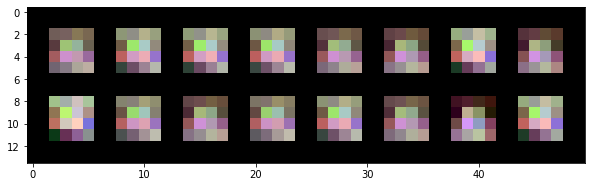

Size: 4; G: 0.281; D: -0.392; Alpha: 1.00000:   1%|          | 8000/800000 [20:45<33:28:20,  6.57it/s] 

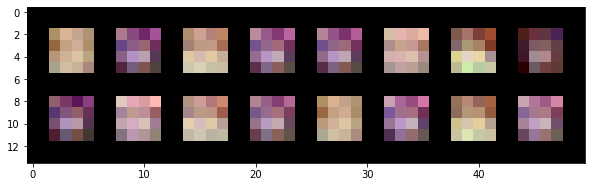

Size: 4; G: 0.427; D: -0.072; Alpha: 1.00000:   2%|▏         | 12000/800000 [31:06<35:15:40,  6.21it/s] 

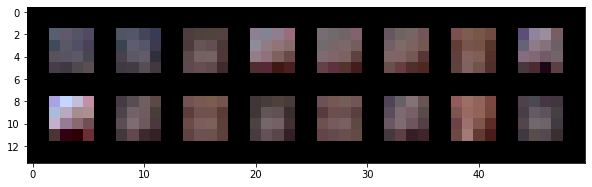

Size: 4; G: -0.024; D: 0.031; Alpha: 1.00000:   2%|▏         | 16000/800000 [41:27<33:48:57,  6.44it/s] 

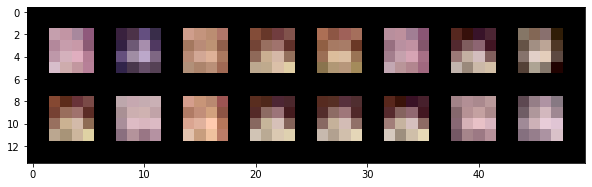

Size: 4; G: 0.204; D: -0.049; Alpha: 1.00000:   2%|▎         | 20000/800000 [51:49<32:42:40,  6.62it/s] 

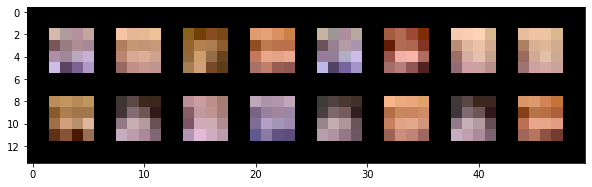

Size: 4; G: 0.116; D: 0.159; Alpha: 1.00000:   3%|▎         | 24000/800000 [1:02:11<33:07:29,  6.51it/s]  

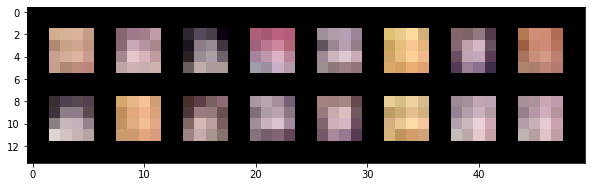

Size: 4; G: 0.088; D: 0.135; Alpha: 1.00000:   4%|▎         | 28000/800000 [1:12:32<33:45:35,  6.35it/s]  

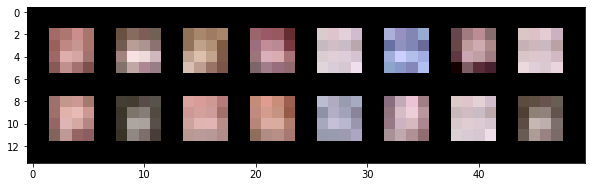

Size: 4; G: -0.060; D: -0.002; Alpha: 1.00000:   4%|▍         | 32000/800000 [1:22:54<31:43:36,  6.72it/s]

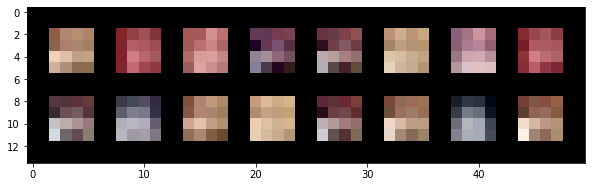

Size: 4; G: 0.122; D: -0.041; Alpha: 1.00000:   4%|▍         | 36000/800000 [1:33:16<32:58:32,  6.44it/s] 

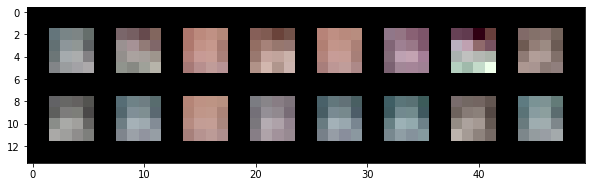

Size: 4; G: 0.156; D: -0.004; Alpha: 1.00000:   5%|▌         | 40000/800000 [1:43:38<31:29:33,  6.70it/s] 

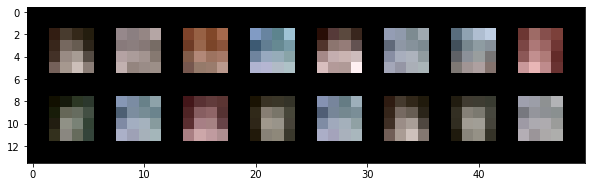

Size: 4; G: -0.011; D: 0.017; Alpha: 1.00000:   6%|▌         | 44000/800000 [1:53:58<31:32:50,  6.66it/s] 

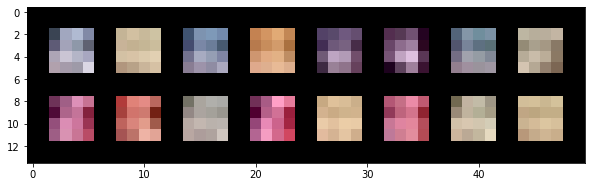

Size: 4; G: 0.043; D: 0.039; Alpha: 1.00000:   6%|▌         | 48000/800000 [2:04:21<32:16:47,  6.47it/s]  

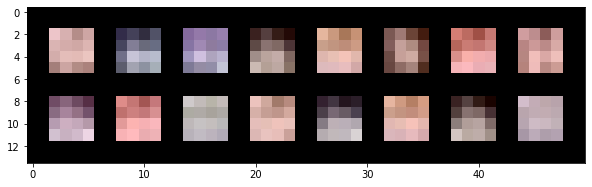

Size: 4; G: 0.103; D: 0.054; Alpha: 1.00000:   6%|▋         | 52000/800000 [2:14:42<33:12:23,  6.26it/s]  

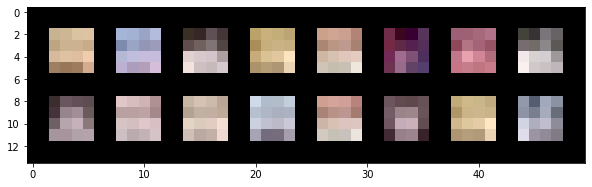

Size: 4; G: 0.005; D: 0.001; Alpha: 1.00000:   7%|▋         | 56000/800000 [2:25:02<32:21:52,  6.39it/s]  

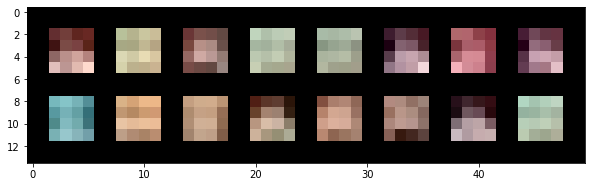

Size: 4; G: -0.021; D: 0.066; Alpha: 1.00000:   8%|▊         | 60000/800000 [2:35:24<31:40:16,  6.49it/s] 

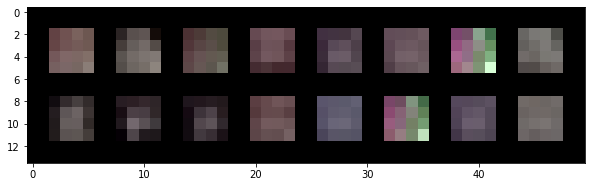

Size: 4; G: 0.032; D: 0.048; Alpha: 1.00000:   8%|▊         | 64000/800000 [2:45:45<31:07:06,  6.57it/s]  

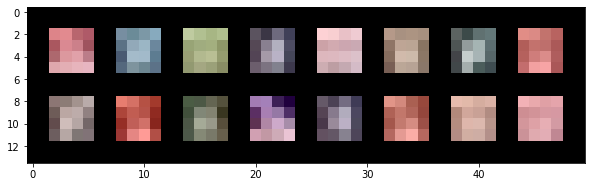

Size: 4; G: 0.034; D: -0.019; Alpha: 1.00000:   8%|▊         | 68000/800000 [2:56:07<31:21:37,  6.48it/s] 

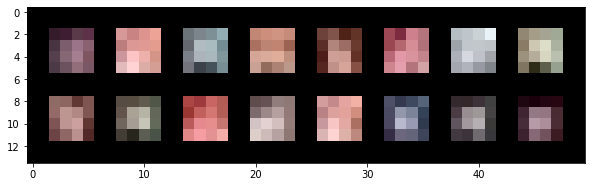

Size: 4; G: -0.004; D: -0.031; Alpha: 1.00000:   9%|▉         | 72000/800000 [3:06:27<31:30:01,  6.42it/s]

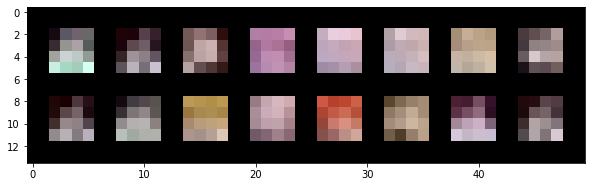

Size: 4; G: 0.077; D: 0.015; Alpha: 1.00000:  10%|▉         | 76000/800000 [3:16:46<31:34:28,  6.37it/s]  

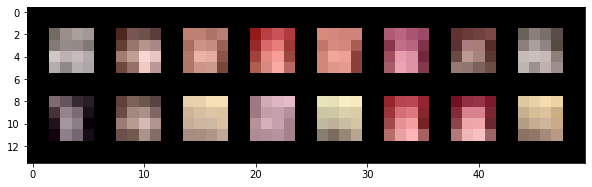

Size: 4; G: 0.003; D: -0.011; Alpha: 1.00000:  10%|█         | 80000/800000 [3:27:08<29:58:56,  6.67it/s] 

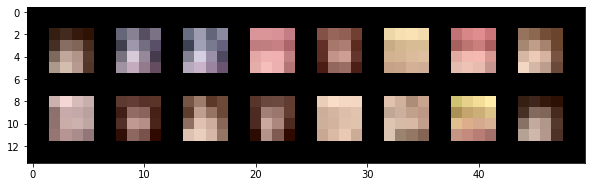

Size: 4; G: -0.060; D: 0.009; Alpha: 1.00000:  10%|█         | 84000/800000 [3:37:32<30:31:57,  6.51it/s] 

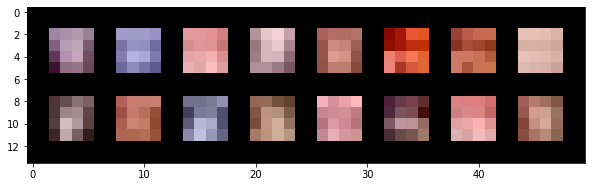

Size: 4; G: 0.008; D: 0.022; Alpha: 1.00000:  11%|█         | 88000/800000 [3:47:54<29:52:40,  6.62it/s]  

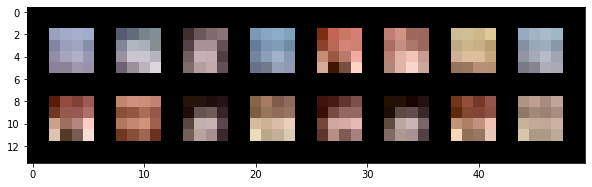

Size: 4; G: -0.006; D: 0.011; Alpha: 1.00000:  12%|█▏        | 92000/800000 [3:58:17<29:48:22,  6.60it/s] 

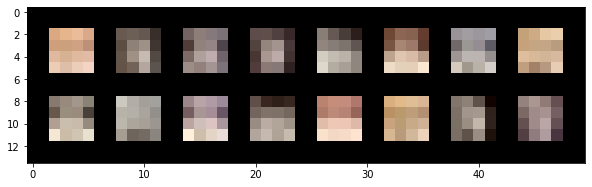

Size: 4; G: 0.083; D: 0.017; Alpha: 1.00000:  12%|█▏        | 96000/800000 [4:08:36<28:45:49,  6.80it/s]  

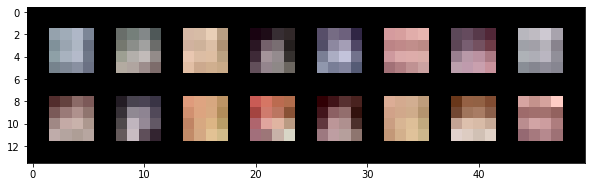

Size: 4; G: 0.028; D: -0.073; Alpha: 1.00000:  12%|█▎        | 100000/800000 [4:18:57<29:43:27,  6.54it/s]

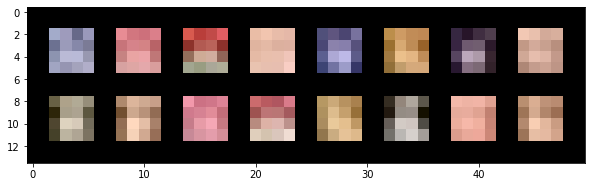

Size: 8; G: -2.420; D: 1.045; Alpha: 0.63969:  13%|█▎        | 104000/800000 [4:30:16<31:15:17,  6.19it/s]     

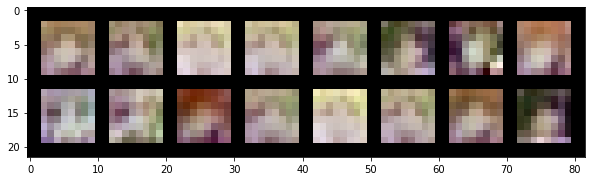

Size: 8; G: -1.372; D: -0.368; Alpha: 1.00000:  14%|█▎        | 108000/800000 [4:41:34<33:06:33,  5.81it/s]

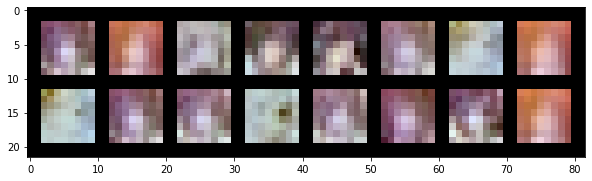

Size: 8; G: -2.590; D: 0.356; Alpha: 1.00000:  14%|█▍        | 112000/800000 [4:52:52<37:39:34,  5.07it/s]  

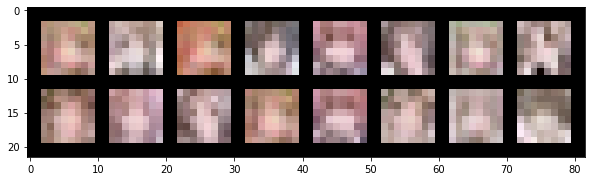

Size: 8; G: 2.306; D: 0.315; Alpha: 1.00000:  14%|█▍        | 116000/800000 [5:04:11<31:25:28,  6.05it/s]  

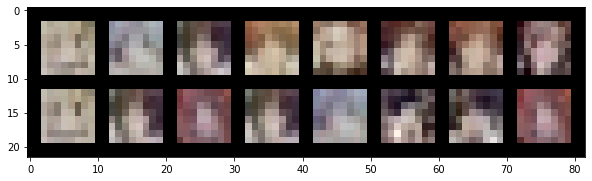

Size: 8; G: 0.088; D: 0.412; Alpha: 1.00000:  15%|█▌        | 120000/800000 [5:15:29<30:55:05,  6.11it/s]  

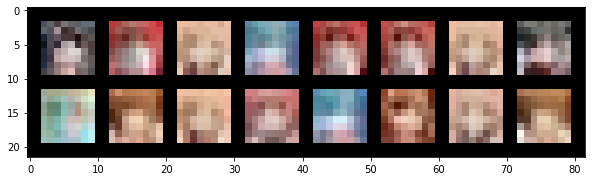

Size: 8; G: -0.235; D: 0.158; Alpha: 1.00000:  16%|█▌        | 124000/800000 [5:26:45<31:45:32,  5.91it/s] 

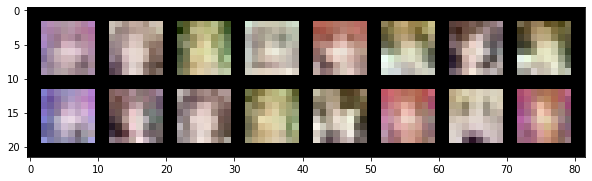

Size: 8; G: -0.207; D: 0.285; Alpha: 1.00000:  16%|█▌        | 128000/800000 [5:38:02<30:39:44,  6.09it/s] 

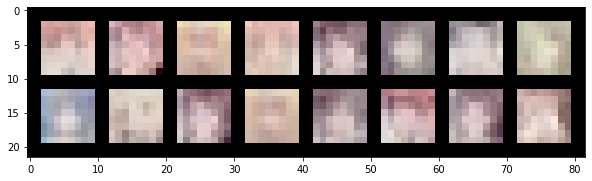

Size: 8; G: 0.385; D: 0.307; Alpha: 1.00000:  16%|█▋        | 132000/800000 [5:49:20<32:40:58,  5.68it/s]  

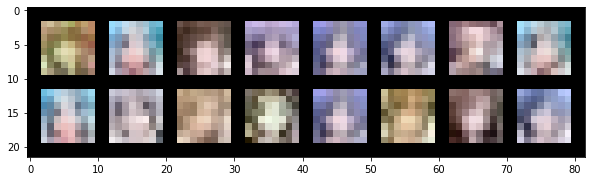

Size: 8; G: -0.101; D: 0.275; Alpha: 1.00000:  17%|█▋        | 136000/800000 [6:00:36<30:36:56,  6.02it/s] 

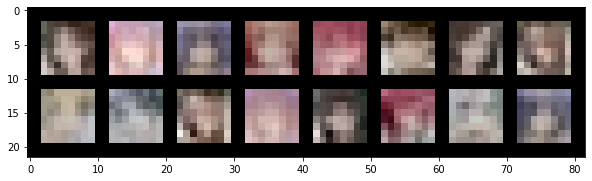

Size: 8; G: 0.329; D: -0.016; Alpha: 1.00000:  18%|█▊        | 140000/800000 [6:11:56<30:50:44,  5.94it/s] 

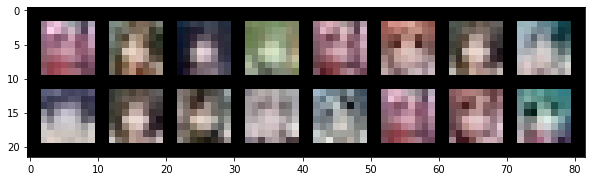

Size: 8; G: 0.038; D: -0.058; Alpha: 1.00000:  18%|█▊        | 144000/800000 [6:23:14<30:29:54,  5.97it/s] 

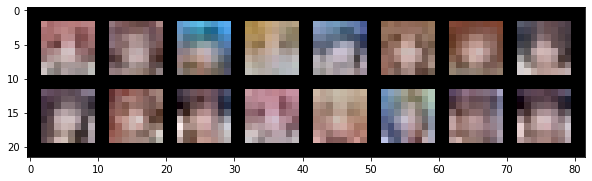

Size: 8; G: 0.009; D: -0.079; Alpha: 1.00000:  18%|█▊        | 148000/800000 [6:34:32<30:12:46,  5.99it/s] 

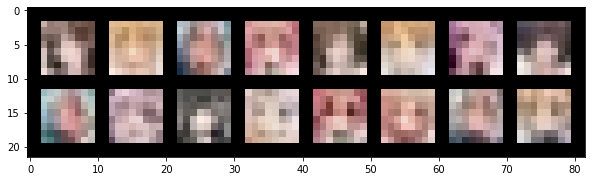

Size: 8; G: 0.322; D: -0.097; Alpha: 1.00000:  19%|█▉        | 152000/800000 [6:45:51<30:20:45,  5.93it/s] 

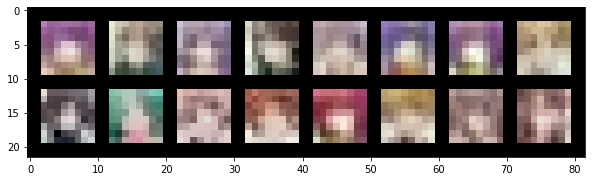

Size: 8; G: -0.313; D: 0.083; Alpha: 1.00000:  20%|█▉        | 156000/800000 [6:57:09<30:18:25,  5.90it/s] 

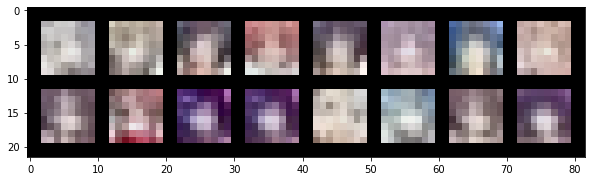

Size: 8; G: 0.263; D: 0.140; Alpha: 1.00000:  20%|██        | 160000/800000 [7:08:27<28:59:53,  6.13it/s]  

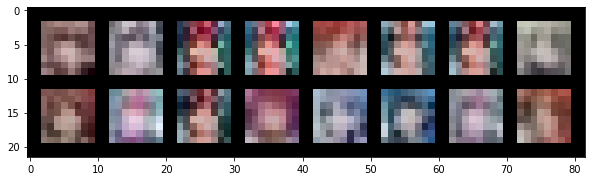

Size: 8; G: 0.110; D: 0.315; Alpha: 1.00000:  20%|██        | 164000/800000 [7:19:45<30:08:08,  5.86it/s]  

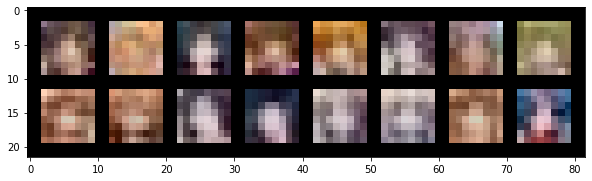

Size: 8; G: 0.057; D: 0.126; Alpha: 1.00000:  21%|██        | 168000/800000 [7:31:03<29:26:26,  5.96it/s]  

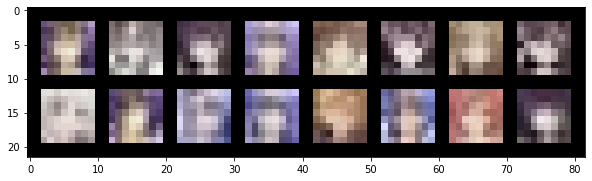

Size: 8; G: 0.298; D: 0.228; Alpha: 1.00000:  22%|██▏       | 172000/800000 [7:42:23<28:40:59,  6.08it/s]  

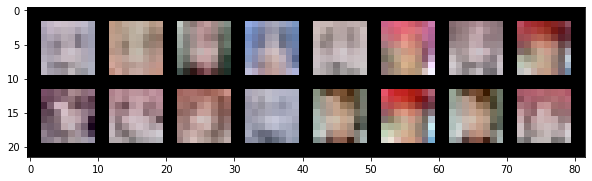

Size: 8; G: 0.175; D: 0.036; Alpha: 1.00000:  22%|██▏       | 176000/800000 [7:53:41<28:54:33,  6.00it/s]  

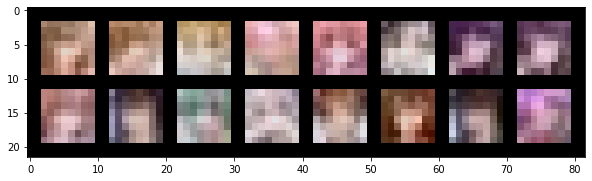

Size: 8; G: 0.215; D: 0.132; Alpha: 1.00000:  22%|██▎       | 180000/800000 [8:04:59<28:52:13,  5.97it/s]  

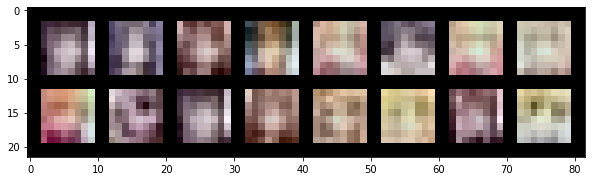

Size: 8; G: -0.154; D: 0.182; Alpha: 1.00000:  23%|██▎       | 184000/800000 [8:16:17<29:30:39,  5.80it/s] 

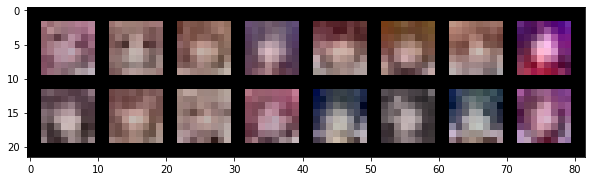

Size: 8; G: 0.063; D: -0.156; Alpha: 1.00000:  24%|██▎       | 188000/800000 [8:27:34<28:20:16,  6.00it/s] 

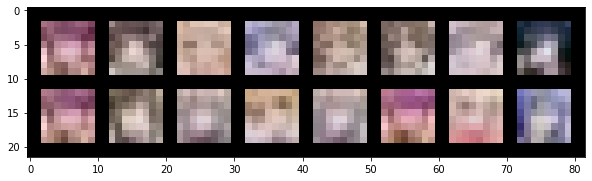

Size: 8; G: 0.115; D: 0.213; Alpha: 1.00000:  24%|██▍       | 192000/800000 [8:38:51<28:40:29,  5.89it/s]  

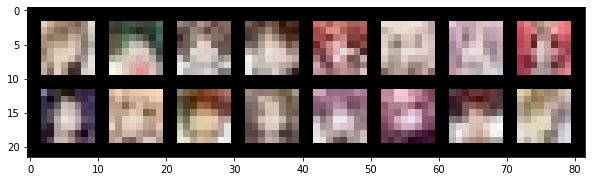

Size: 8; G: 0.727; D: -0.201; Alpha: 1.00000:  24%|██▍       | 196000/800000 [8:50:09<28:23:42,  5.91it/s] 

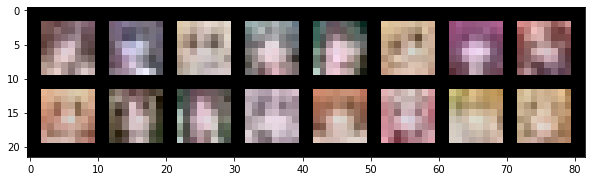

Size: 8; G: 0.302; D: -0.168; Alpha: 1.00000:  25%|██▌       | 200000/800000 [9:01:25<28:03:58,  5.94it/s] 

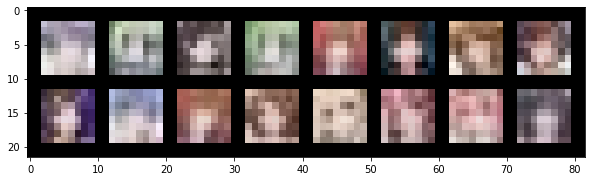

Size: 16; G: -161.987; D: 752.523; Alpha: 0.63953:  26%|██▌       | 204000/800000 [9:14:24<32:25:54,  5.10it/s]      

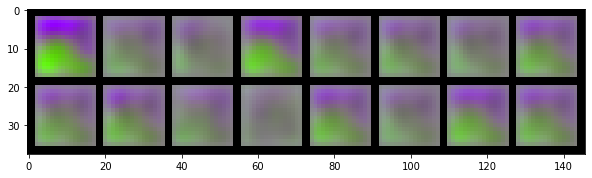

Size: 16; G: -1.201; D: 2.263; Alpha: 1.00000:  26%|██▌       | 208000/800000 [9:27:22<31:43:49,  5.18it/s]     

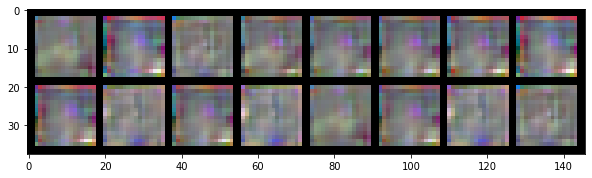

Size: 16; G: 1.479; D: 0.618; Alpha: 1.00000:  26%|██▋       | 212000/800000 [9:40:20<31:38:52,  5.16it/s]  

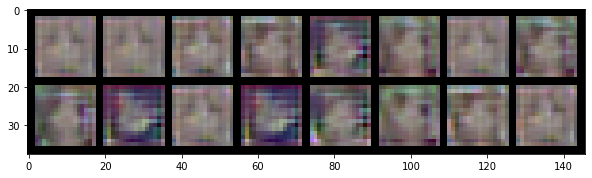

Size: 16; G: 10.642; D: -1.214; Alpha: 1.00000:  27%|██▋       | 216000/800000 [9:53:19<31:03:56,  5.22it/s]

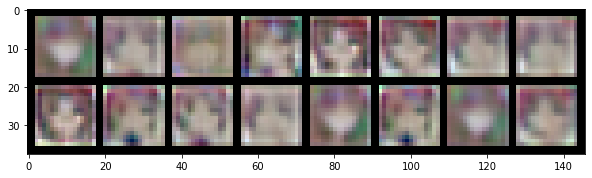

Size: 16; G: 5.912; D: 10.028; Alpha: 1.00000:  28%|██▊       | 220000/800000 [10:06:20<31:20:05,  5.14it/s]        

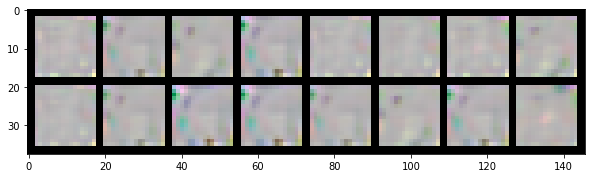

Size: 16; G: -3.040; D: 1.600; Alpha: 1.00000:  28%|██▊       | 224000/800000 [10:19:18<30:30:19,  5.24it/s]  

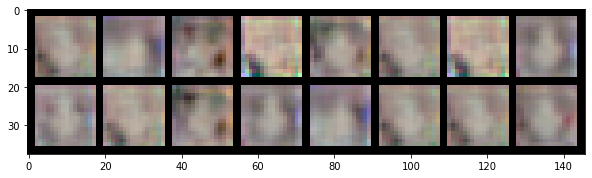

Size: 16; G: 10.397; D: -1.547; Alpha: 1.00000:  28%|██▊       | 228000/800000 [10:32:16<30:37:21,  5.19it/s]

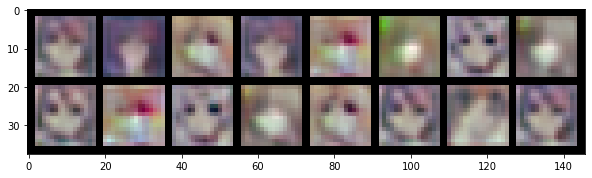

Size: 16; G: -37.472; D: 60.415; Alpha: 1.00000:  29%|██▉       | 232000/800000 [10:45:14<30:06:58,  5.24it/s]         

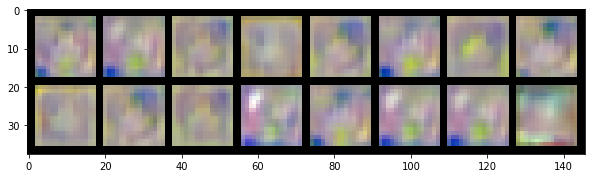

Size: 16; G: 0.140; D: 1.060; Alpha: 1.00000:  30%|██▉       | 236000/800000 [10:58:12<30:40:34,  5.11it/s]    

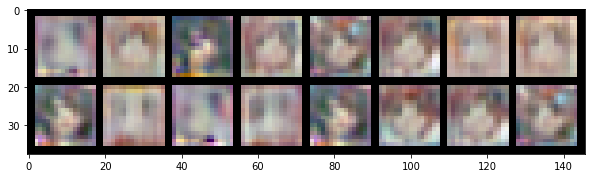

Size: 16; G: -2.660; D: 0.906; Alpha: 1.00000:  30%|███       | 240000/800000 [11:11:12<31:05:09,  5.00it/s]  

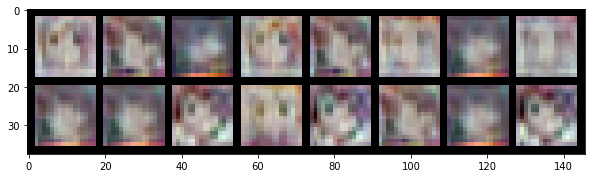

Size: 16; G: -5.003; D: 10.986; Alpha: 1.00000:  30%|███       | 244000/800000 [11:24:10<30:11:01,  5.12it/s]          

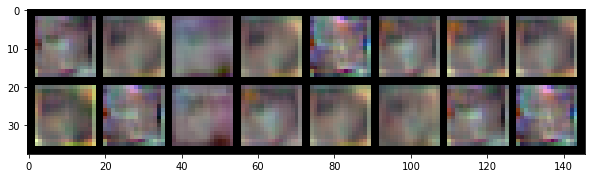

Size: 16; G: 1.184; D: 2.688; Alpha: 1.00000:  31%|███       | 248000/800000 [11:37:10<30:37:00,  5.01it/s]   

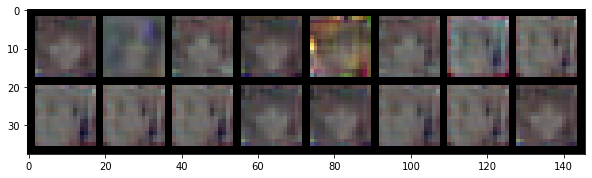

Size: 16; G: 3.512; D: 2.196; Alpha: 1.00000:  32%|███▏      | 252000/800000 [11:50:09<30:06:03,  5.06it/s]   

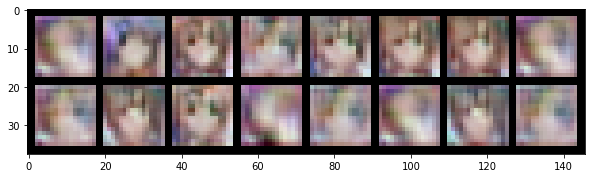

Size: 16; G: -3.562; D: 2.509; Alpha: 1.00000:  32%|███▏      | 256000/800000 [12:03:10<30:39:18,  4.93it/s]       

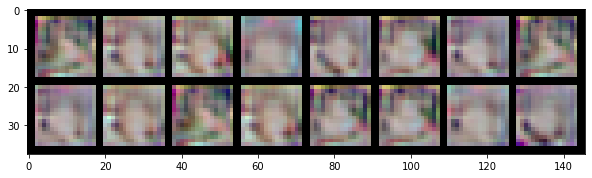

Size: 16; G: -2.481; D: 0.782; Alpha: 1.00000:  32%|███▎      | 260000/800000 [12:16:10<29:52:12,  5.02it/s] 

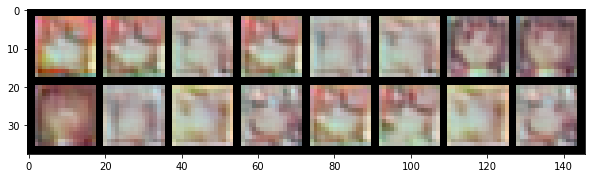

Size: 16; G: -0.360; D: 16.030; Alpha: 1.00000:  33%|███▎      | 264000/800000 [12:29:09<28:32:50,  5.22it/s]        

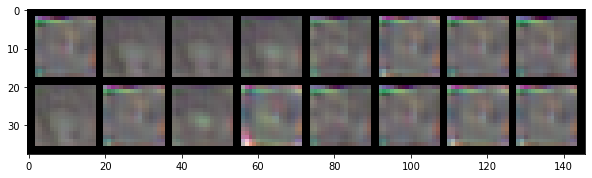

Size: 16; G: -3.908; D: 0.701; Alpha: 1.00000:  34%|███▎      | 268000/800000 [12:42:08<28:18:21,  5.22it/s]  

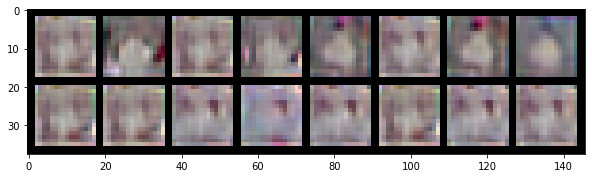

Size: 16; G: -0.435; D: 2.206; Alpha: 1.00000:  34%|███▍      | 272000/800000 [12:55:09<28:40:01,  5.12it/s] 

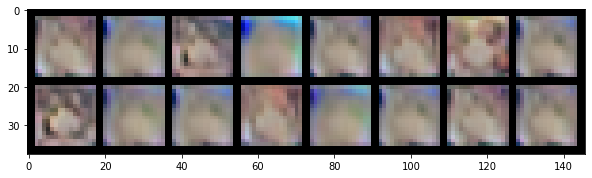

Size: 16; G: -28.631; D: 19.133; Alpha: 1.00000:  34%|███▍      | 276000/800000 [13:08:07<27:42:25,  5.25it/s]         

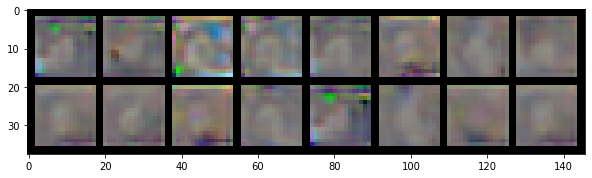

Size: 16; G: 1.362; D: 2.229; Alpha: 1.00000:  35%|███▌      | 280000/800000 [13:21:06<27:34:36,  5.24it/s]   

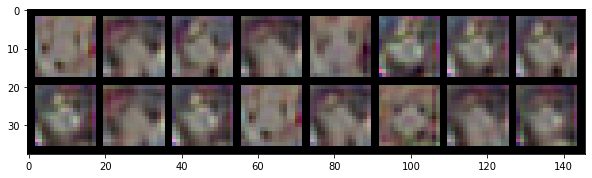

Size: 16; G: -2.154; D: 1.115; Alpha: 1.00000:  36%|███▌      | 284000/800000 [13:34:06<27:16:11,  5.26it/s] 

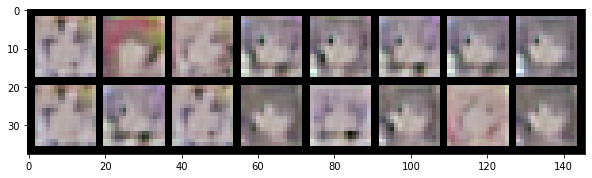

Size: 16; G: -119.517; D: 312.598; Alpha: 1.00000:  36%|███▌      | 288000/800000 [13:47:05<27:05:43,  5.25it/s]      

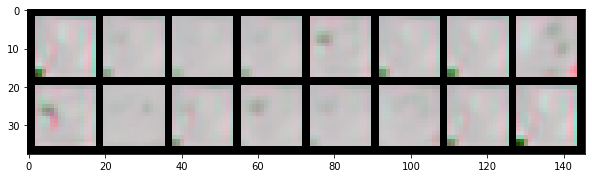

Size: 16; G: -11.769; D: 6.524; Alpha: 1.00000:  36%|███▋      | 292000/800000 [14:00:03<27:50:00,  5.07it/s]   

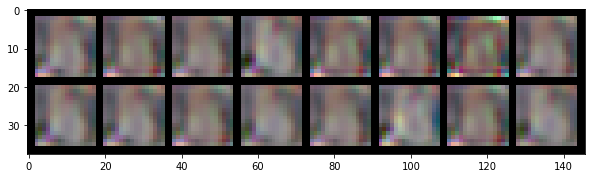

Size: 16; G: -5.191; D: 3.295; Alpha: 1.00000:  37%|███▋      | 296000/800000 [14:13:02<27:17:35,  5.13it/s]   

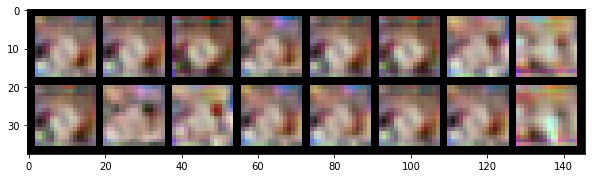

Size: 16; G: 12.743; D: 0.539; Alpha: 1.00000:  38%|███▊      | 300000/800000 [14:26:01<26:03:01,  5.33it/s]   

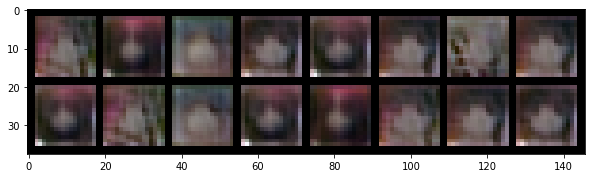

Size: 32; G: 0.221; D: 0.851; Alpha: 0.63937:  38%|███▊      | 304000/800000 [14:42:36<34:40:05,  3.97it/s]            

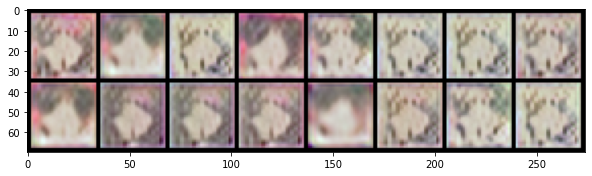

Size: 32; G: -8693.365; D: 399806.219; Alpha: 1.00000:  38%|███▊      | 308000/800000 [14:59:07<34:28:58,  3.96it/s]        

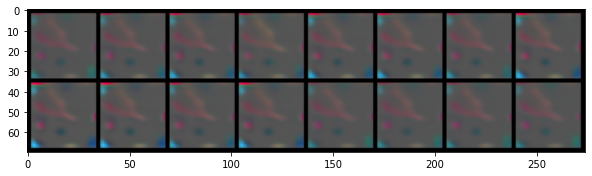

Size: 32; G: -1321.518; D: 18120.387; Alpha: 1.00000:  39%|███▉      | 312000/800000 [15:15:40<34:03:55,  3.98it/s]   

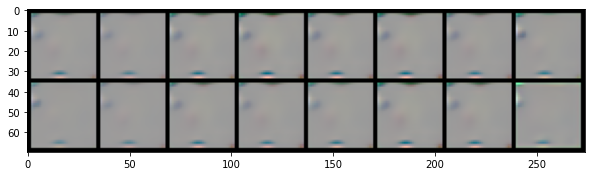

Size: 32; G: 109.149; D: 2080.403; Alpha: 1.00000:  40%|███▉      | 316000/800000 [15:32:12<32:37:04,  4.12it/s]   

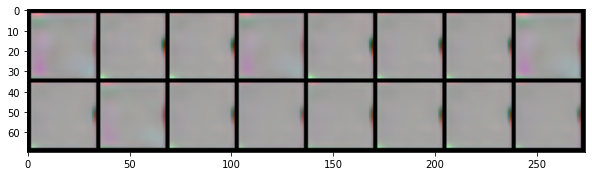

Size: 32; G: 16.320; D: 163.734; Alpha: 1.00000:  40%|████      | 320000/800000 [15:48:45<33:17:39,  4.00it/s]    

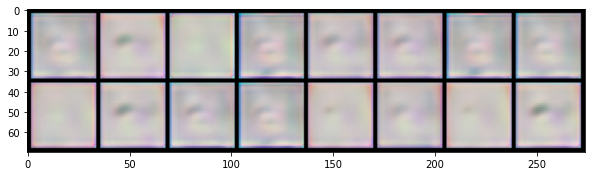

Size: 32; G: -613.074; D: 5351.562; Alpha: 1.00000:  40%|████      | 324000/800000 [16:05:19<32:19:40,  4.09it/s]         

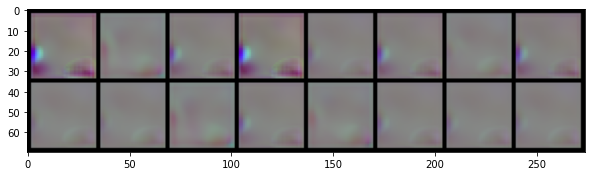

Size: 32; G: -5.336; D: 203.095; Alpha: 1.00000:  41%|████      | 328000/800000 [16:21:51<32:24:43,  4.05it/s]     

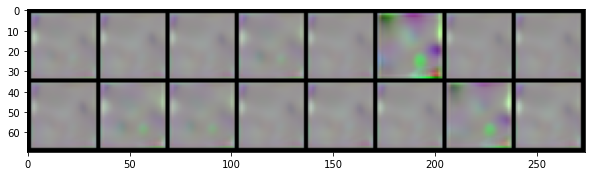

Size: 32; G: 0.349; D: 13.742; Alpha: 1.00000:  42%|████▏     | 332000/800000 [16:38:22<31:58:13,  4.07it/s]      

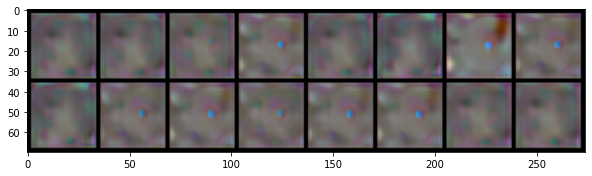

Size: 32; G: -2118.276; D: 62915.172; Alpha: 1.00000:  42%|████▏     | 336000/800000 [16:54:54<31:32:41,  4.09it/s]        

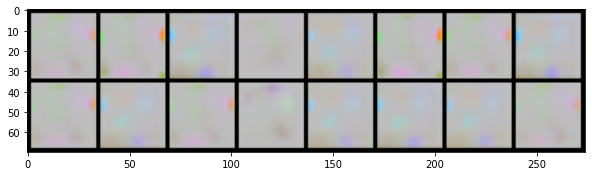

Size: 32; G: 322.486; D: 20345.932; Alpha: 1.00000:  42%|████▎     | 340000/800000 [17:11:25<31:31:34,  4.05it/s]   

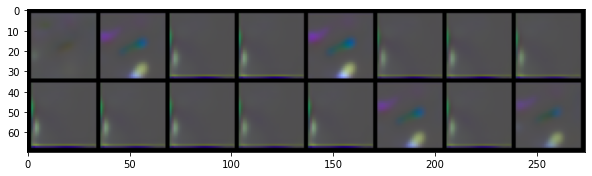

Size: 32; G: -130.934; D: 1374.360; Alpha: 1.00000:  43%|████▎     | 344000/800000 [17:27:56<31:43:56,  3.99it/s] 

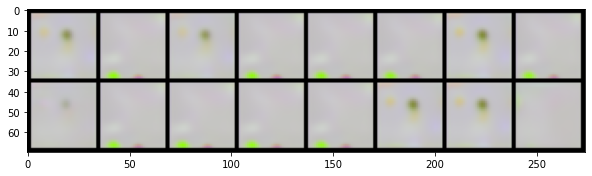

Size: 32; G: -12227.755; D: 204154.500; Alpha: 1.00000:  44%|████▎     | 348000/800000 [17:44:26<30:32:20,  4.11it/s]     

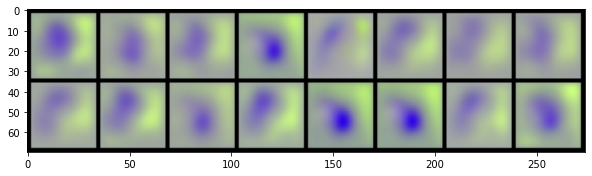

Size: 32; G: -876.279; D: 21236.154; Alpha: 1.00000:  44%|████▍     | 352000/800000 [18:00:59<30:40:41,  4.06it/s]    

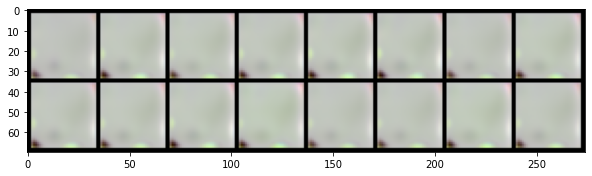

Size: 32; G: -72.537; D: 1669.785; Alpha: 1.00000:  44%|████▍     | 356000/800000 [18:17:33<30:33:24,  4.04it/s]   

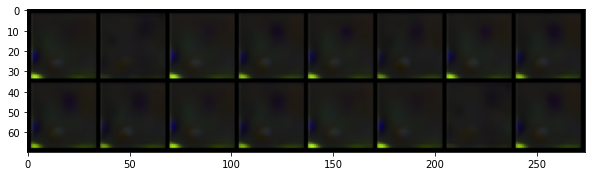

Size: 32; G: -6.310; D: 58.705; Alpha: 1.00000:  45%|████▌     | 360000/800000 [18:34:06<29:38:18,  4.12it/s]    

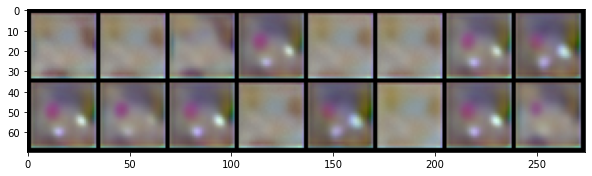

Size: 32; G: 19302.682; D: 810275.250; Alpha: 1.00000:  46%|████▌     | 364000/800000 [18:50:38<29:24:53,  4.12it/s]           

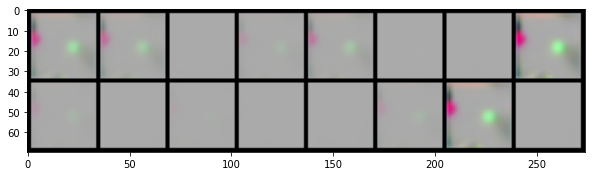

Size: 32; G: -1906.512; D: 89257.617; Alpha: 1.00000:  46%|████▌     | 368000/800000 [19:07:11<29:23:08,  4.08it/s]   

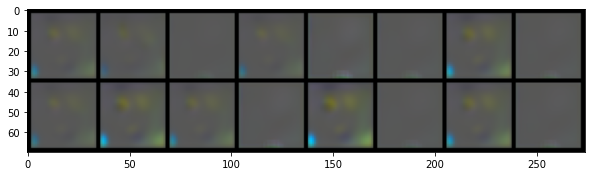

Size: 32; G: -177.020; D: 13229.673; Alpha: 1.00000:  46%|████▋     | 372000/800000 [19:23:43<29:08:07,  4.08it/s]  

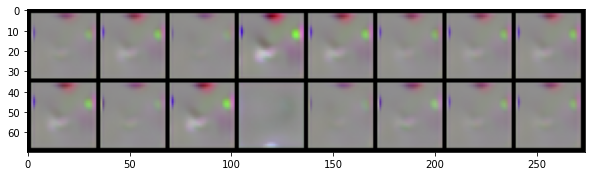

Size: 32; G: -495.229; D: 6712.015; Alpha: 1.00000:  47%|████▋     | 376000/800000 [19:40:16<28:49:07,  4.09it/s]  

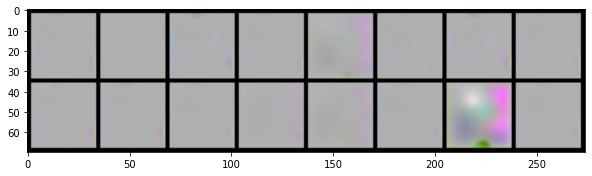

Size: 32; G: -21.733; D: 239.378; Alpha: 1.00000:  48%|████▊     | 380000/800000 [19:56:47<29:03:23,  4.02it/s]   

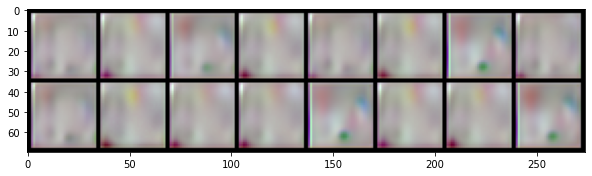

Size: 32; G: 6099.400; D: 355699.438; Alpha: 1.00000:  48%|████▊     | 384000/800000 [20:13:20<28:42:16,  4.03it/s]            

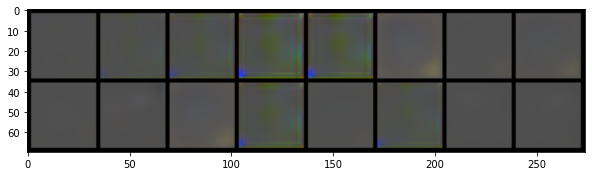

Size: 32; G: 864.127; D: 109200.570; Alpha: 1.00000:  48%|████▊     | 388000/800000 [20:29:52<28:11:36,  4.06it/s]    

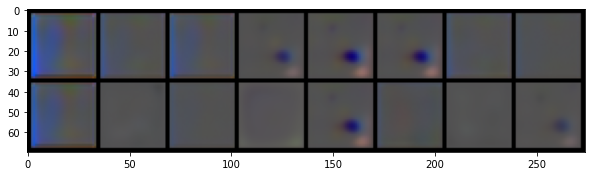

Size: 32; G: -63.755; D: 11438.408; Alpha: 1.00000:  49%|████▉     | 392000/800000 [20:46:24<28:16:24,  4.01it/s]   

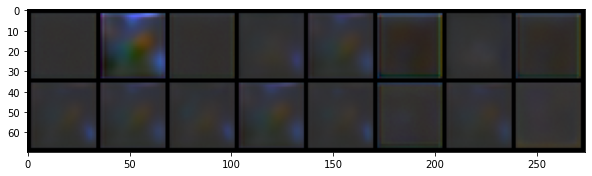

Size: 32; G: 2731.000; D: 291204.281; Alpha: 1.00000:  50%|████▉     | 396000/800000 [21:02:55<27:43:27,  4.05it/s]         

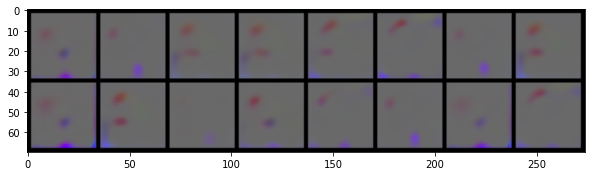

Size: 32; G: 1133.522; D: 25356.623; Alpha: 1.00000:  50%|█████     | 400000/800000 [21:19:26<27:15:57,  4.08it/s]   

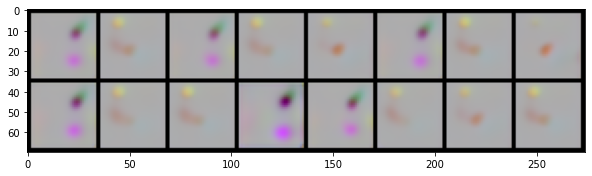

Size: 64; G: 281.030; D: 294.402; Alpha: 0.00321:  50%|█████     | 400025/800000 [21:19:40<21:19:30,  5.21it/s]      


KeyboardInterrupt: 

In [48]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1, 2, 3'
trainer = TrainProcessing(dataset)
trainer.train()

## Test

In [166]:
class Test:
    def __init__(self, latent_code_dim=512, model_path='./checkpoint/train_step-4.model', level=4):
        latent = torch.randn(1, 512, 1, 1)
        generator_test = StyledGenerator(5)
        generator_test.load_state_dict(torch.load('./checkpoint/train_step-4.model')['generator'])
        img_tensor = generator_test(latent, level)
        plt.imshow(img_tensor.squeeze(0).permute(1, 2, 0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


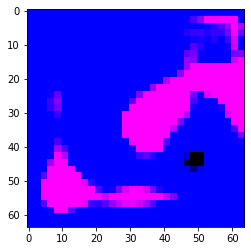

In [175]:
Test()